# Analisis Karakteristik Data Audio
Source code ini digunakan untuk mengetahui karakteristik data audio dari dataset ArDad dengan 30 imam terkenal. Diharapkan dengan analisis ini dapat membantu dalam proses preprocessing data audio dan menjadi dasar untuk pengambilan keputusan terkait dengan fitur audio yang diambil. Kemudian perbandingan anatara penggunaan tensor vs librosa dala mengolah data audio.

### Import Library

In [1]:
import tensorflow as tf
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt  
import os
import tensorflow_io as tfio
import torch
import torchaudio

2024-06-21 10:08:07.420809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-21 10:08:07.420967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-21 10:08:07.513498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-21 10:08:07.800873: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 10:08:10.718220: W tensorflow/compiler/tf2

## Function to Extract Audio Features

### Define Function General

In [2]:
def get_shape_and_dtype(audio):
    return audio.shape, audio.dtype

In [3]:
def plot_waveform(audio, sr, title):
    # plot the first audio file
    d = len(audio) / sr
    t = np.linspace(0, d, len(audio))
    plt.figure(figsize=(14, 5))
    plt.plot(t, audio)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Waveform of ' + title)

In [4]:
def plot_spectrogram(title, spectrogram, sr):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.title(title)

### Define Librosa Function

In [5]:
def load_audio_lb(file):
    audio, sr = librosa.load(file)
    return audio, sr

In [6]:
def get_spectrogram_lb(audio, n_fft=2048, hop_length=512):
    spectrogram = np.abs(librosa.stft(audio, win_length=n_fft, hop_length=hop_length, n_fft=n_fft, center=False))    
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram

In [7]:
def get_mel_spectrogram_lb(audio,  sr, n_fft=2048, hop_length=512, n_mels=128):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, center=False)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

### Define Tensor Function

In [8]:
def load_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    return audio, sr

In [9]:
def get_spectrogram_tf(audio, n_fft=2048, hop_length=512):
    # get the spectrogram
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.transpose(spectrogram)
    spectrogram = 10 * tf.math.log(spectrogram + 1e-9)
    return spectrogram

In [10]:
def get_mel_spectrogram_tf(audio, sr, n_fft=2048, hop_length=512, n_mels=128):
    # plot the mel spectrogram using tensorflow
    spectrogram = tf.signal.stft(audio, frame_length=n_fft, frame_step=hop_length, fft_length=n_fft)
    spectrogram = tf.abs(spectrogram)    
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels, 
        num_spectrogram_bins=spectrogram.shape[-1], 
        sample_rate=sr,
        lower_edge_hertz=20.0,
        upper_edge_hertz=sr/2.0
    )
    # mel_filter = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    # mel_filter = tf.convert_to_tensor(mel_filter, dtype=tf.float32)
    # mel_filter = tf.transpose(mel_filter)
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    mel_spectrogram = tf.transpose(mel_spectrogram)
    mel_spectrogram = 10 * tf.math.log(mel_spectrogram + 1e-9)
    return mel_spectrogram

In [11]:
def load_16k_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    sr = tf.cast(sr, tf.int64)
    audio = tf.squeeze(audio, axis=1)
    audio = tfio.audio.resample(audio, sr, 16000)
    return audio

### Define Torchaudio Function

In [12]:
def load_audio_ta(file):
    audio, sr = torchaudio.load(file)
    # get only one channel
    audio = audio[0]
    audio = audio.squeeze(0)
    return audio, sr

In [13]:
def load_16k_audio_ta(file):
    # define the resample rate
    resample_rate = 16000
    # load the audio file
    audio, sr = load_audio_ta(file)
    resampler = torchaudio.transforms.Resample(sr, resample_rate, dtype=audio.dtype)
    resampled_waveform = resampler(audio)
    return resampled_waveform, resample_rate

## Analisis Data Audio


### Initial Setup

In [14]:
files = []

# librosa
lb_audios = []
lb_srs = []

# tensorflow
tf_audios = []
tf_16k_audios = []
tf_srs = []

# torchaudio
ta_audios = []
ta_16k_audios = []
ta_srs = []

root_folder = "karakteristik_data"
# iterate over all files in data folder
for file in os.listdir(root_folder):
    if file.endswith('.wav'):
        files.append(file)
files.sort()

for file in files:
    file = root_folder+ '/' + file

    # load audio file with librosa
    lb_audio, lb_sr = load_audio_lb(file)
    lb_audios.append(lb_audio)
    lb_srs.append(lb_sr)

    # load audio file with tensorflow
    tf_audio, tf_sr = load_audio_tf(file) 
    tf_16k_audio = load_16k_audio_tf(file)
    tf_16k_audios.append(tf_16k_audio)
    tf_audios.append(tf_audio)
    tf_srs.append(tf_sr)
    
    # load audio file with torchaudio
    ta_audio, ta_sr = load_audio_ta(file)
    ta_16k_audio, ta_16k_sr = load_16k_audio_ta(file)
    ta_16k_audios.append(ta_16k_audio)
    ta_audios.append(ta_audio)
    ta_srs.append(ta_sr)

2024-06-21 10:08:56.683642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 10:08:56.695682: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 10:08:56.695780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 10:08:56.700952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-21 10:08:56.701076: I external/local_xla/xla/stream_executor

### Total Sample and Sample Rate

In [15]:
index = 0

# Librosa
print("librosa audio : ", get_shape_and_dtype(lb_audios[index]), lb_srs[index])

# TensorFlow
print("tensor audio : ", get_shape_and_dtype(tf_audios[index]), tf_srs[index])
print("tensor 16k audio : ", get_shape_and_dtype(tf_16k_audios[index]), 16000)

# Torchaudio
print("torchaudio audio : ", get_shape_and_dtype(ta_audios[index]), ta_srs[index])
print("torchaudio 16k audio : ", get_shape_and_dtype(ta_16k_audios[index]), 16000)

librosa audio :  ((112896,), dtype('float32')) 22050
tensor audio :  (TensorShape([112896]), tf.float32) tf.Tensor(22050, shape=(), dtype=int32)
tensor 16k audio :  (TensorShape([81920]), tf.float32) 16000
torchaudio audio :  (torch.Size([112896]), torch.float32) 22050
torchaudio 16k audio :  (torch.Size([81920]), torch.float32) 16000


In [27]:
tf_audios[0]

<tf.Tensor: shape=(112896,), dtype=float32, numpy=
array([-6.1035156e-05, -6.1035156e-05, -3.0517578e-05, ...,
        1.5258789e-04,  5.4931641e-04,  1.0375977e-03], dtype=float32)>

### Play Audio

In [17]:
ipd.Audio(lb_audios[index], rate=lb_srs[index])

In [17]:
ipd.Audio(tf_audios[index].numpy(), rate=tf_srs[index].numpy())

In [18]:
ipd.Audio(tf_16k_audios[index], rate=16000)

In [19]:
ipd.Audio(ta_audios[index].numpy(), rate=ta_srs[index])

In [20]:
ipd.Audio(ta_16k_audios[index].numpy(), rate=16000)

### Waveform

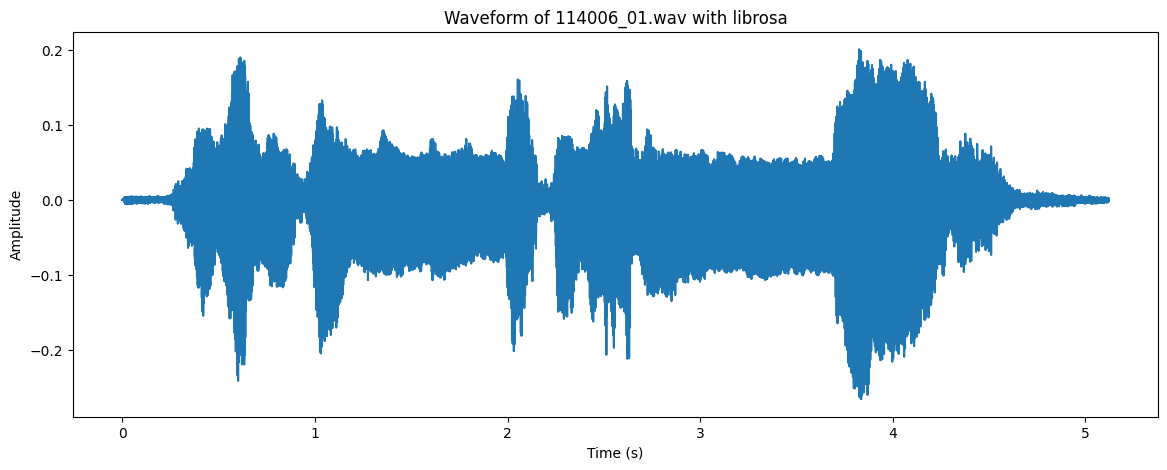

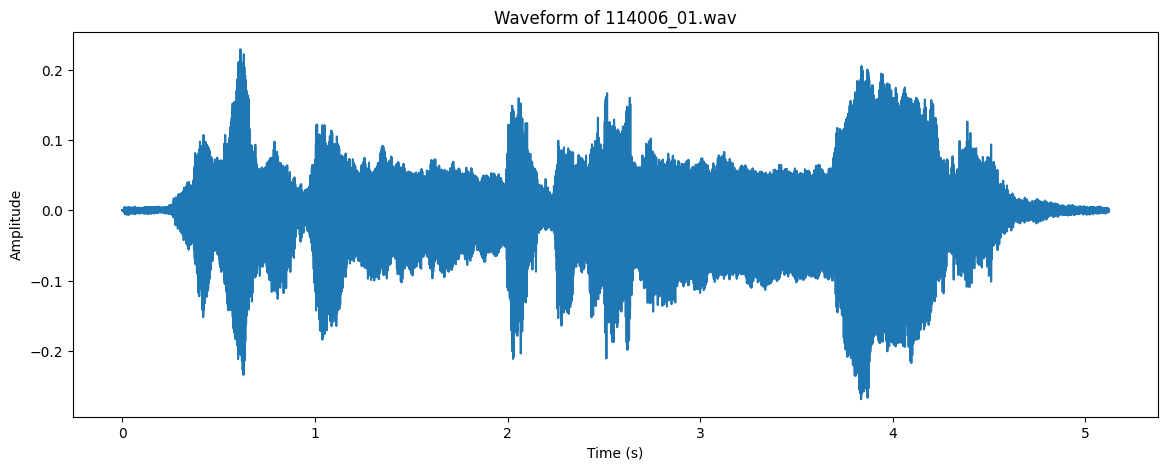

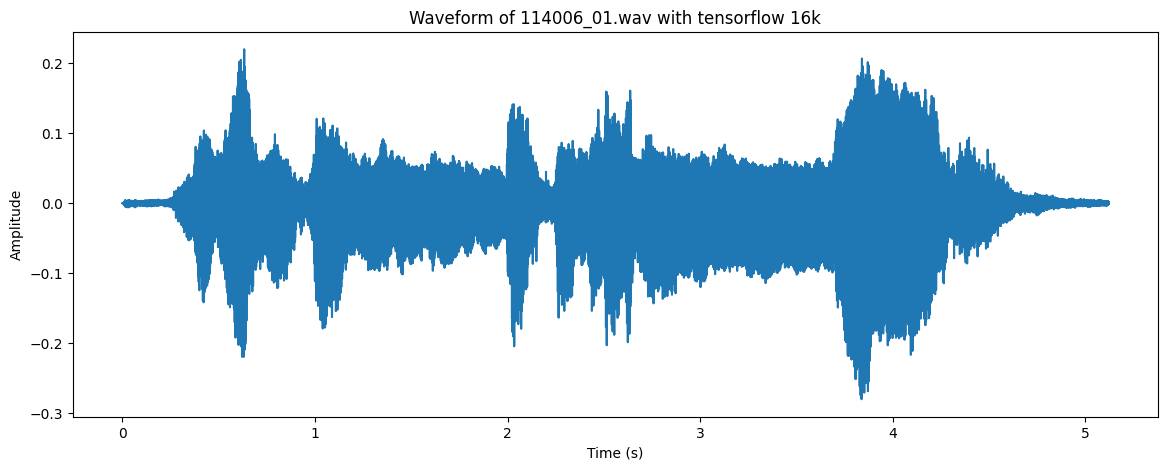

In [26]:
index = 0
# plot the first audio file
plot_waveform(lb_audios[index], lb_srs[index], files[index]+" with librosa")
plot_waveform(tf_audios[index].numpy(), tf_srs[index].numpy(), files[index])
plot_waveform(tf_16k_audios[index].numpy(), 16000, files[index] + " with tensorflow 16k")

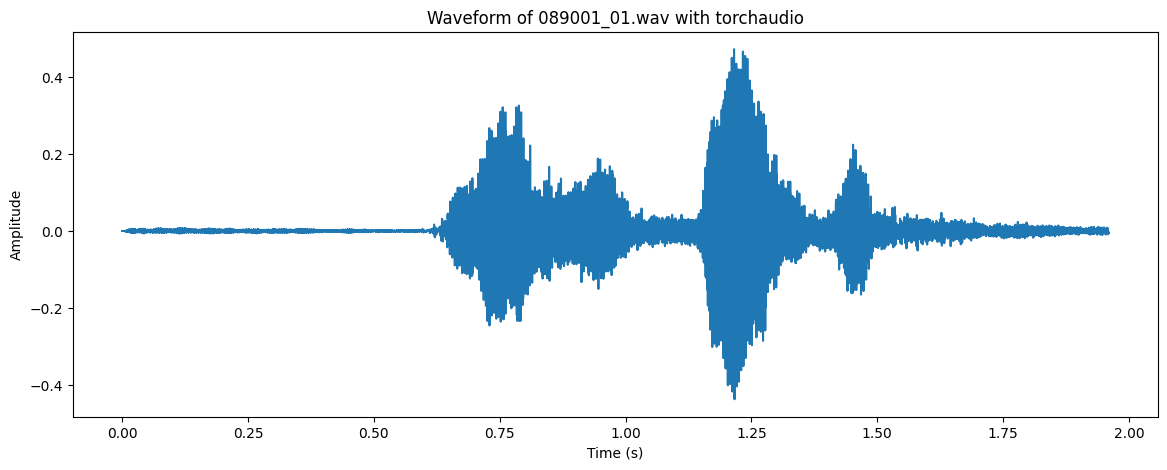

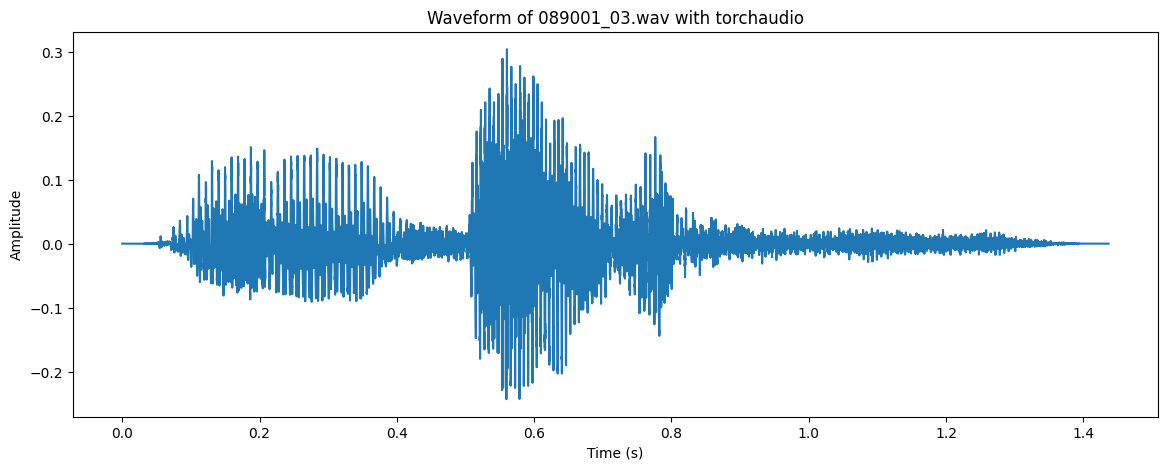

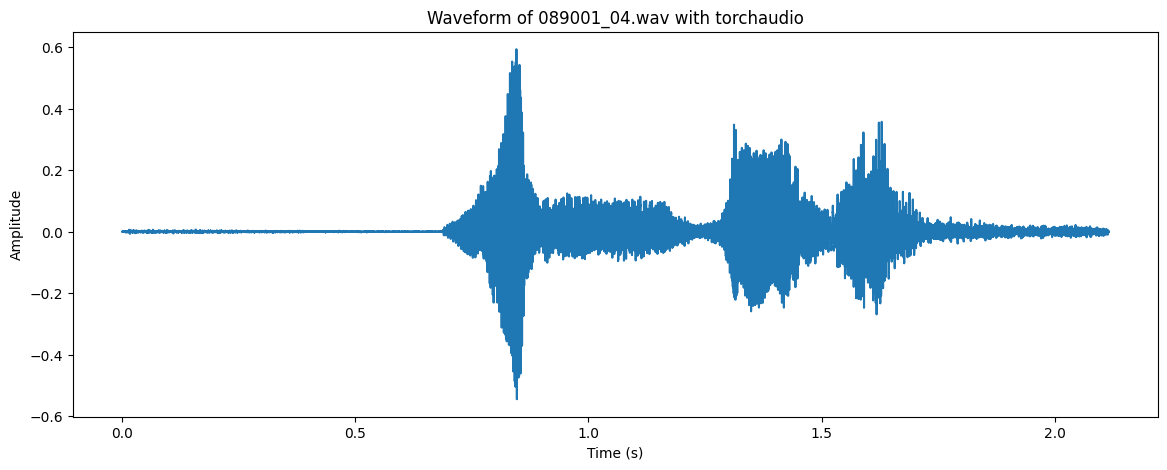

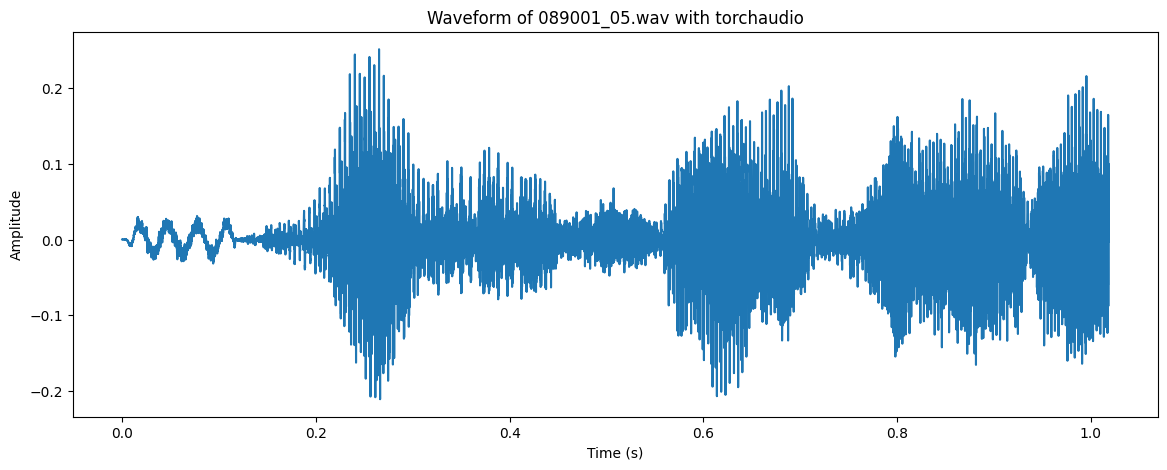

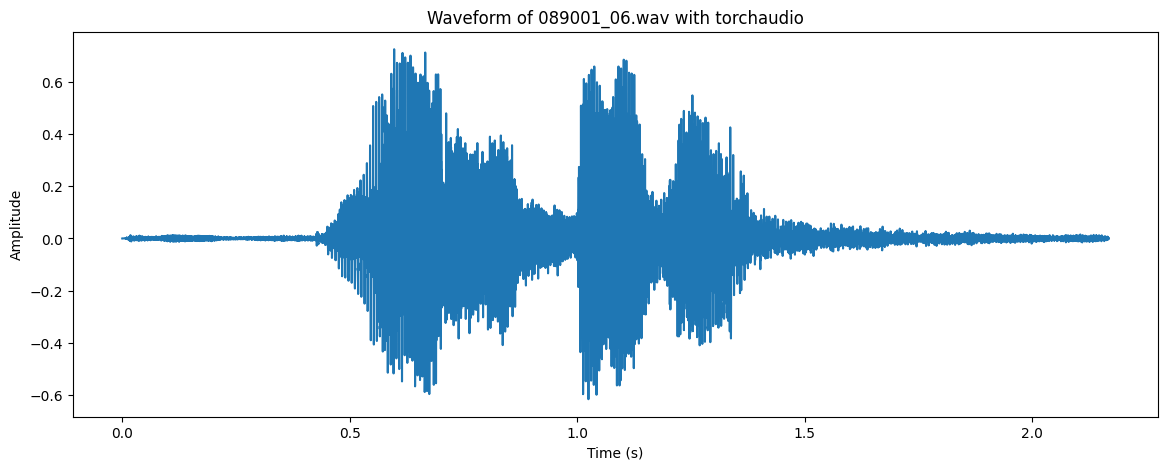

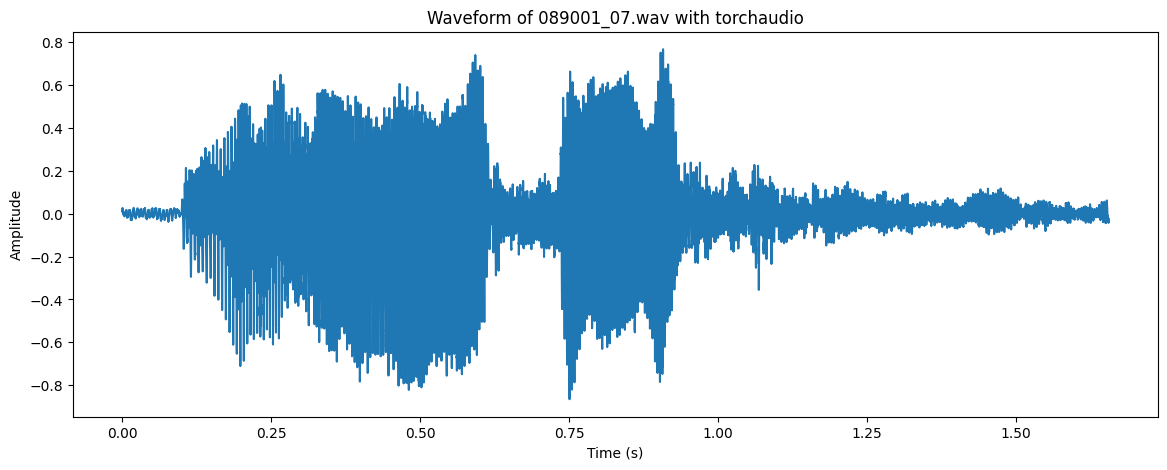

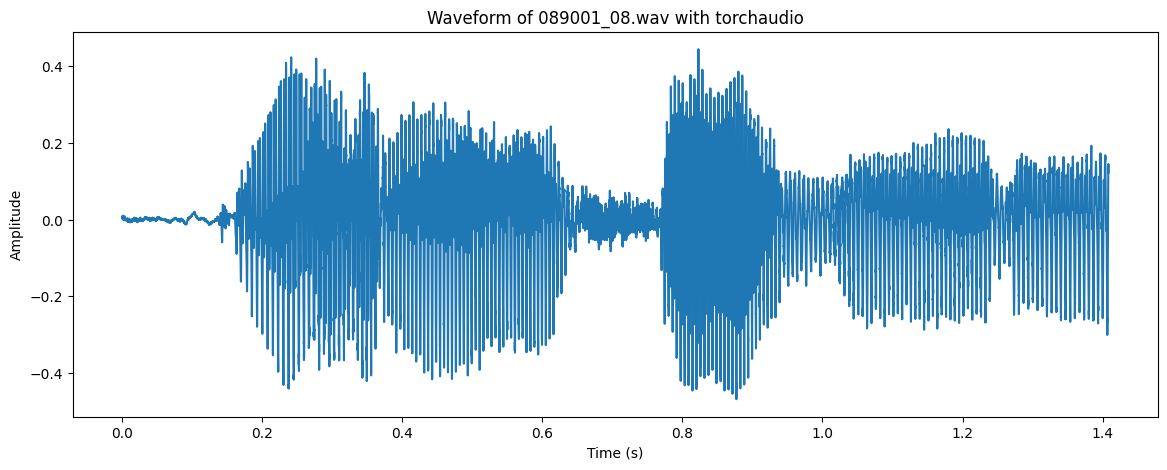

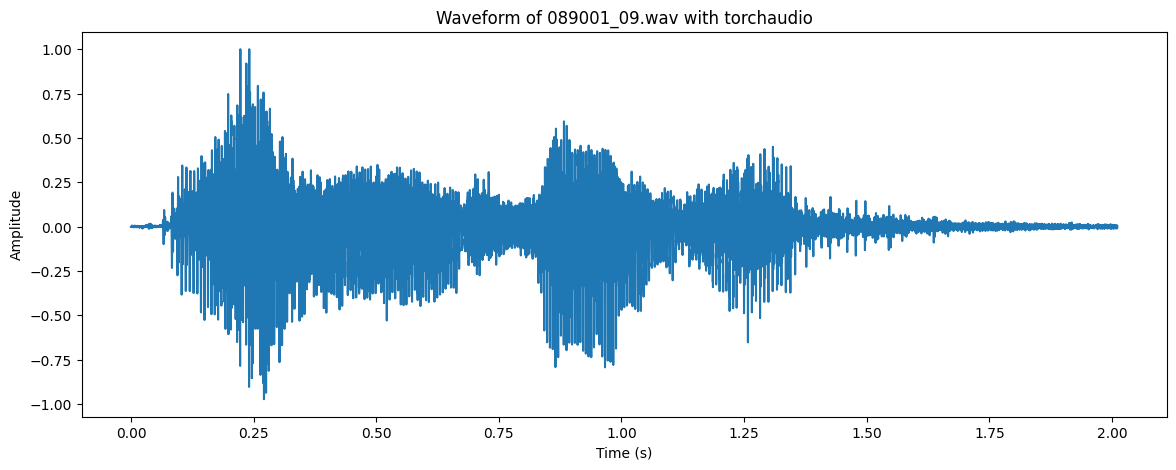

In [22]:
# plot wave form with torchaudio of all audio files
for i in range(len(ta_audios)):
    plot_waveform(ta_audios[i].numpy(), ta_srs[i], files[i] + " with torchaudio")

### Spectrum

Text(0, 0.5, 'Amplitude')

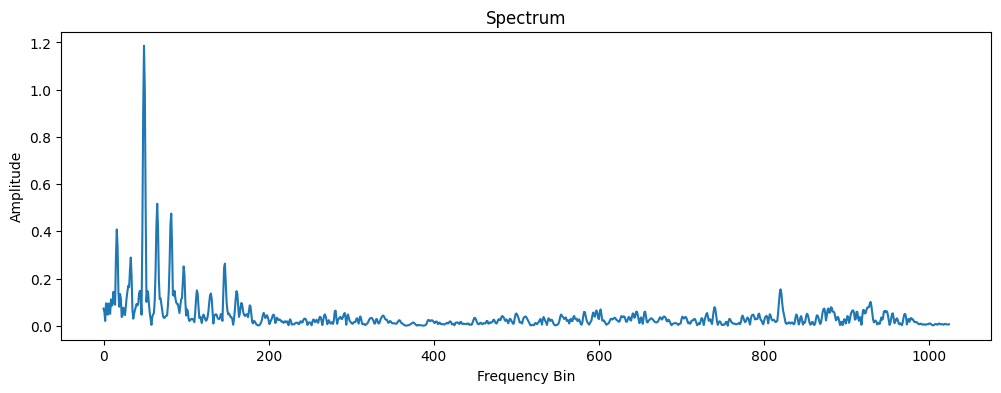

In [32]:
# create spectrum with librosa
n_fft = 2048
plt.figure(figsize=(12, 4))
ft = np.abs(librosa.stft(lb_audios[index][:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency Bin')
plt.ylabel('Amplitude')


### Spectogram

(401, 281) float32


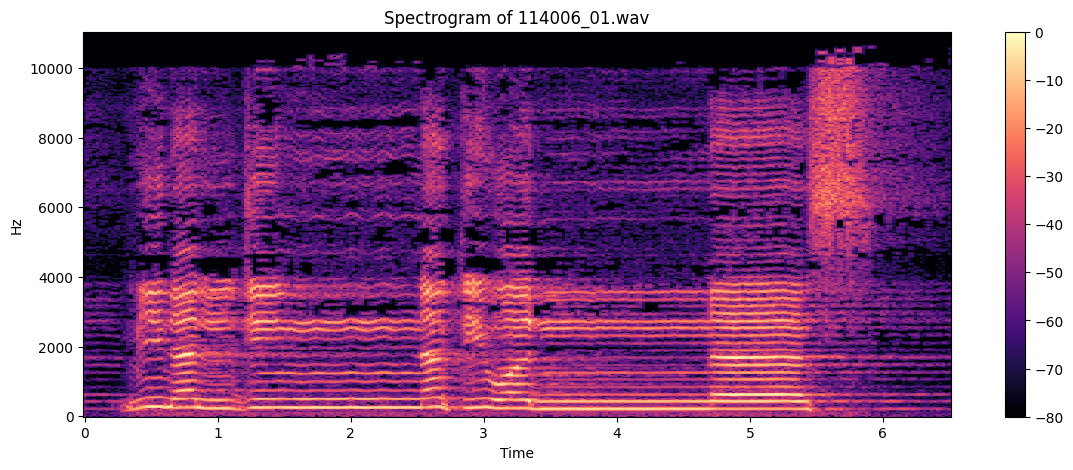

In [25]:
index = 0
# Parameter
frame_size = 800
hop_size = frame_size // 2

spec_lb = get_spectrogram_lb(lb_audios[index], frame_size, hop_size)
plot_spectrogram('Spectrogram of ' + files[index]+"", spec_lb, lb_srs[index])

# spec_tf = get_spectrogram_tf(tf_audios[index].numpy(),  frame_size, hop_size)
# plot_spectrogram('Spectrogram of ' + files[index]+" with tensorflow", spec_tf, tf_srs[index])

# spec_tf_16k = get_spectrogram_tf(tf_16k_audios[index].numpy(),  frame_size, hop_size)
# plot_spectrogram('Spectrogram of ' + files[index]+" with tensorflow 16k", spec_tf_16k, 16000)

print(spec_lb.shape, spec_lb.dtype)
# print(spec_tf.shape, spec_tf.dtype)

### Mel Spectogram

(128, 281) float32
(128, 454) float32
(128, 348) float32
(128, 324) float32
(128, 379) float32
(128, 391) float32
(128, 588) float32
(128, 435) float32


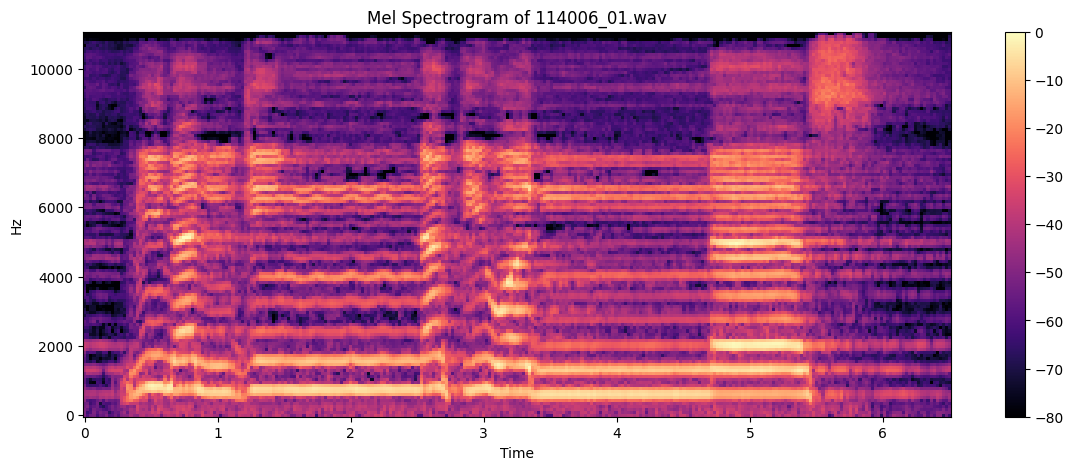

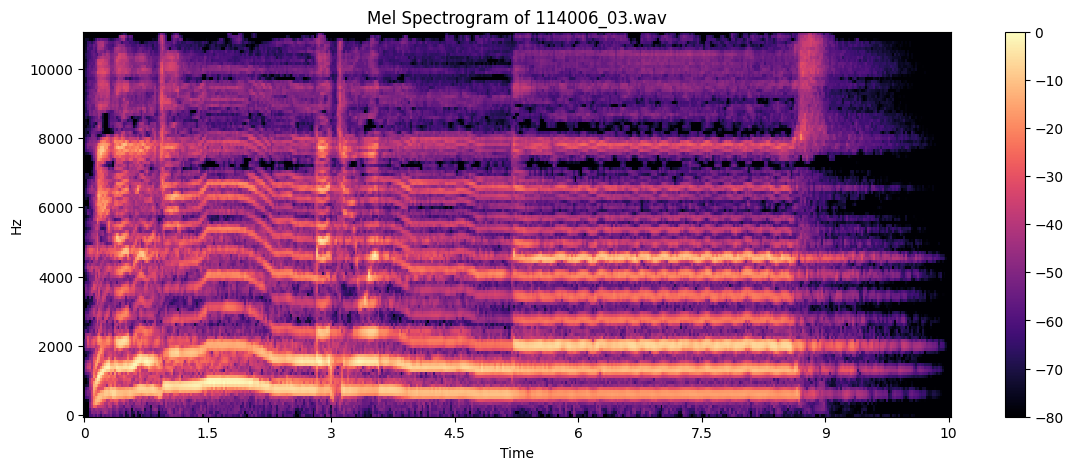

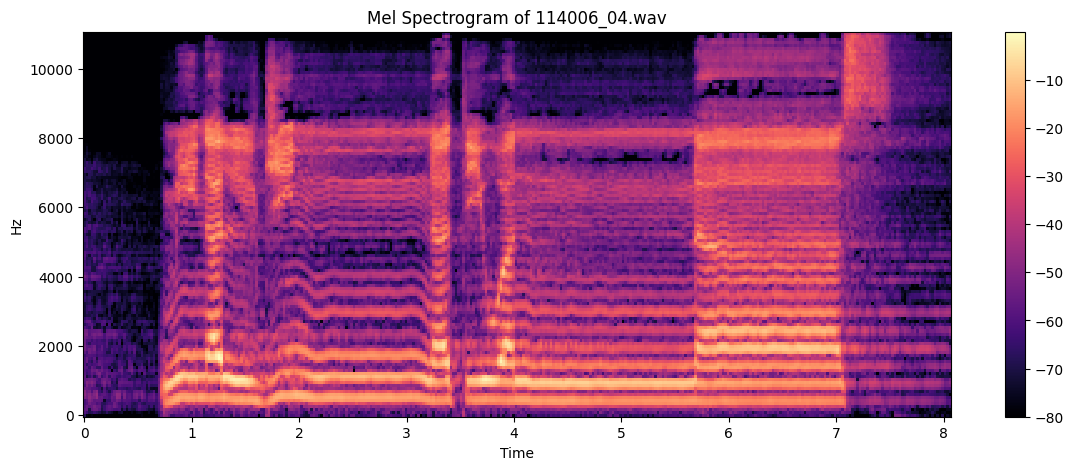

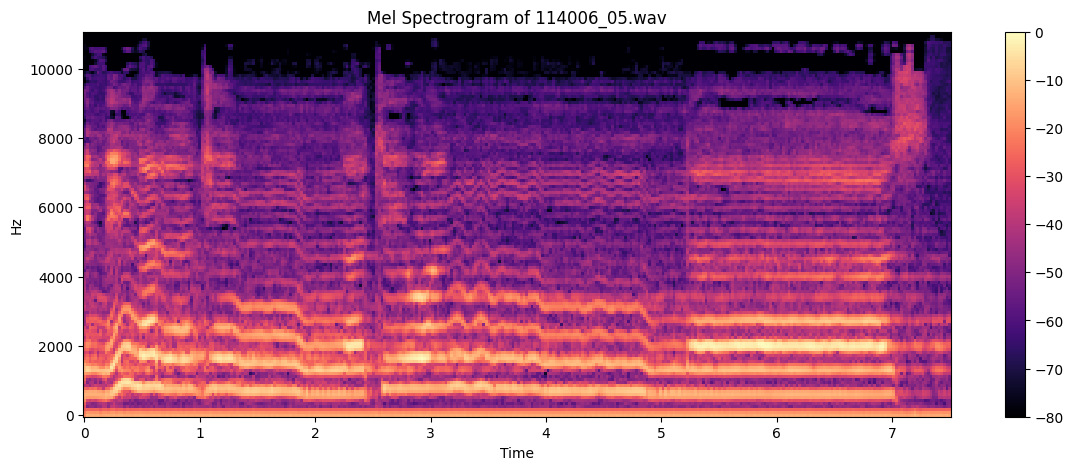

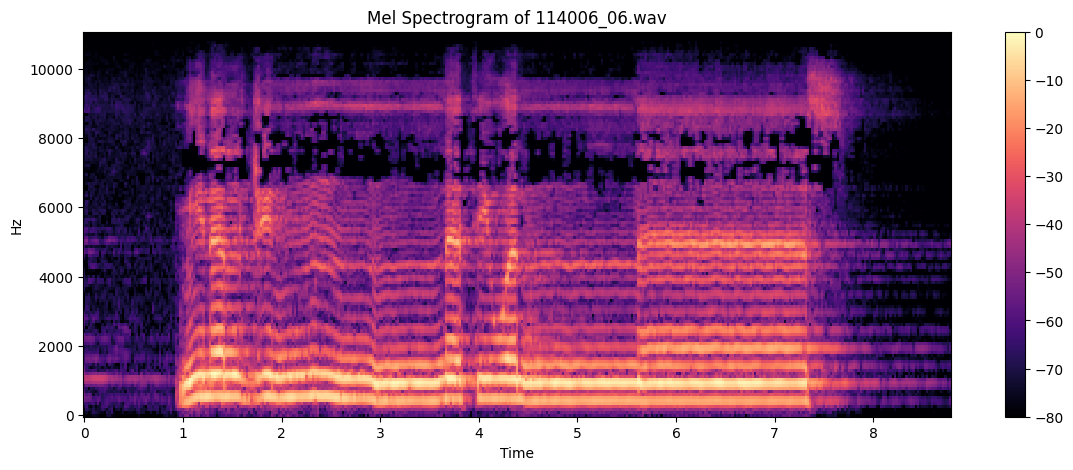

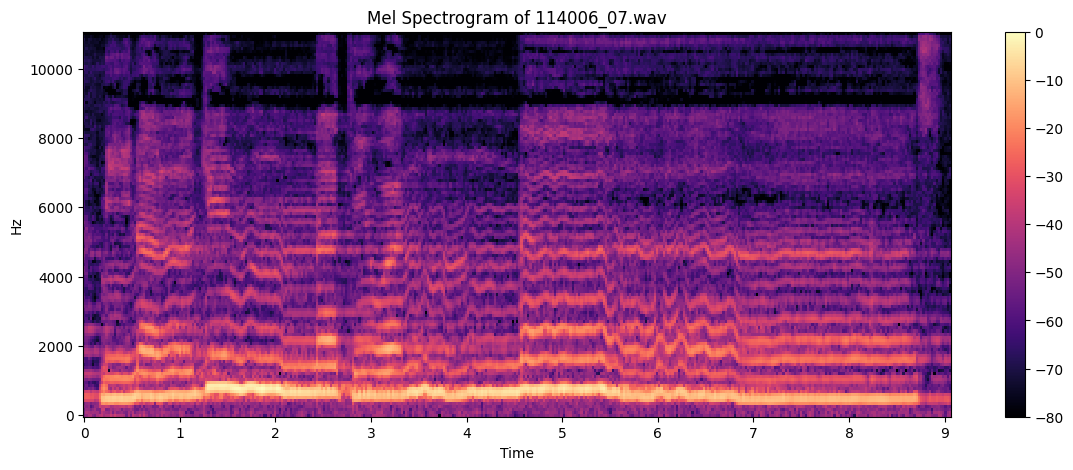

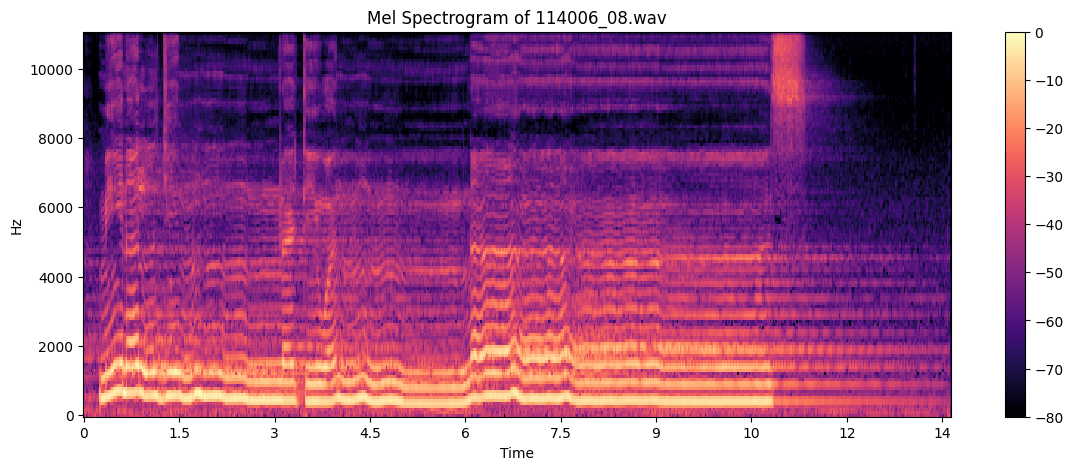

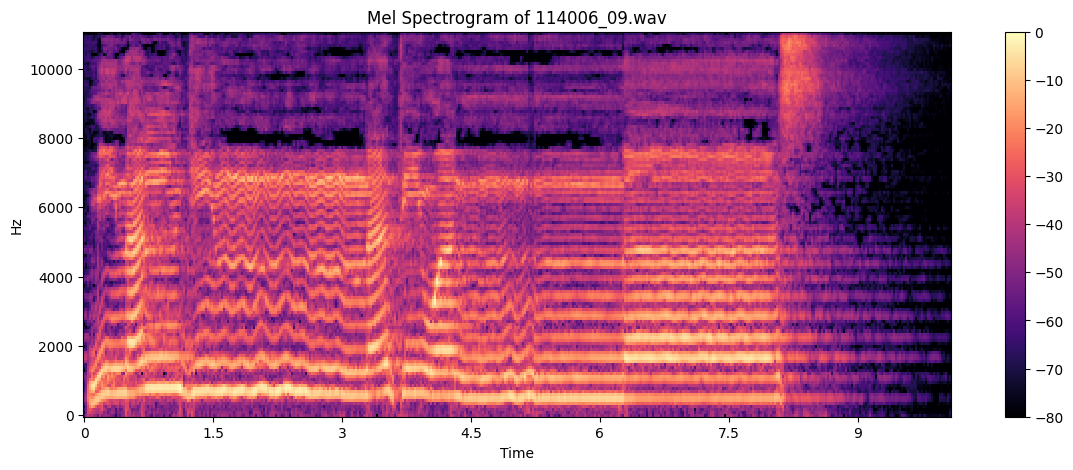

In [30]:
# Parameter
frame_size = 800
hop_size = frame_size // 2
n_mel = 128


# Loop untuk indeks 0 hingga 7
for index in range(len(files)):
    # mel spectrogram dengan librosa
    mel_spec_lb = get_mel_spectrogram_lb(lb_audios[index], lb_srs[index], frame_size, hop_size, n_mel)
    print(mel_spec_lb.shape, mel_spec_lb.dtype)
    
    # show the mel spectrogram
    plot_spectrogram('Mel Spectrogram of ' + files[index]+"", mel_spec_lb, lb_srs[index])

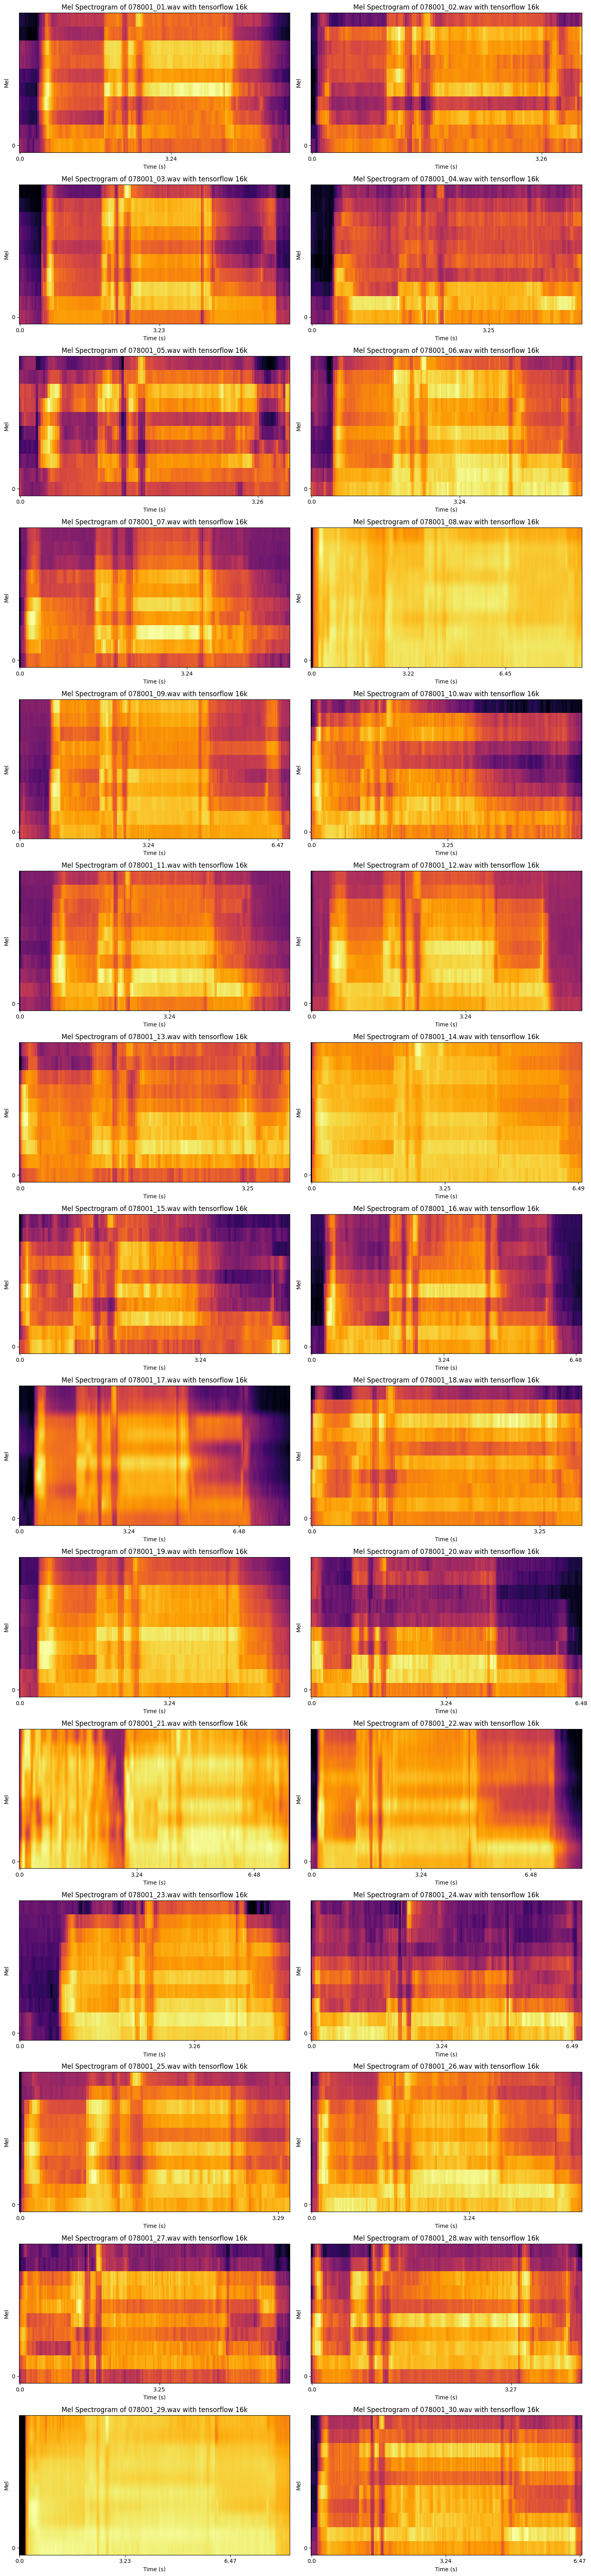

In [27]:
# Parameter
frame_size = 1024
hop_size = 512
n_mel = 10

# Inisialisasi plot
fig, axes = plt.subplots(15, 2, figsize=(15, 65))

# Loop untuk indeks 0 hingga 7
for index in range(30):
    mel_spec_tf = get_mel_spectrogram_tf(tf_16k_audios[index].numpy(), 16000, frame_size, hop_size, n_mel)
    # create lin space time
    t = np.linspace(0, len(tf_16k_audios[index]) / 16000, mel_spec_tf.shape[1])
    # plot mel spectrogram
    ax = axes[index // 2, index % 2]
    ax.imshow(mel_spec_tf, aspect='auto', origin='lower', cmap='inferno')
    ax.set_title('Mel Spectrogram of ' + files[index] + ' with tensorflow 16k')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mel')
    ax.set_xticks(np.arange(0, len(t), 100))
    ax.set_xticklabels(np.round(t[::100], 2))
    ax.set_yticks(np.arange(0, n_mel, 10))
    ax.set_yticklabels(np.arange(0, n_mel, 10))    
    # ax.label_outer()  # Hide x labels and tick labels for top plots and y ticks for right plots

# Menampilkan plot
plt.tight_layout()
plt.show()

jumlah sample audio librosa 131418
jumlah sample audio tensorflow 131418
frekuensi bins 1025
frames librosa 253
frames tensorflow 253
(128, 253) (128, 253)


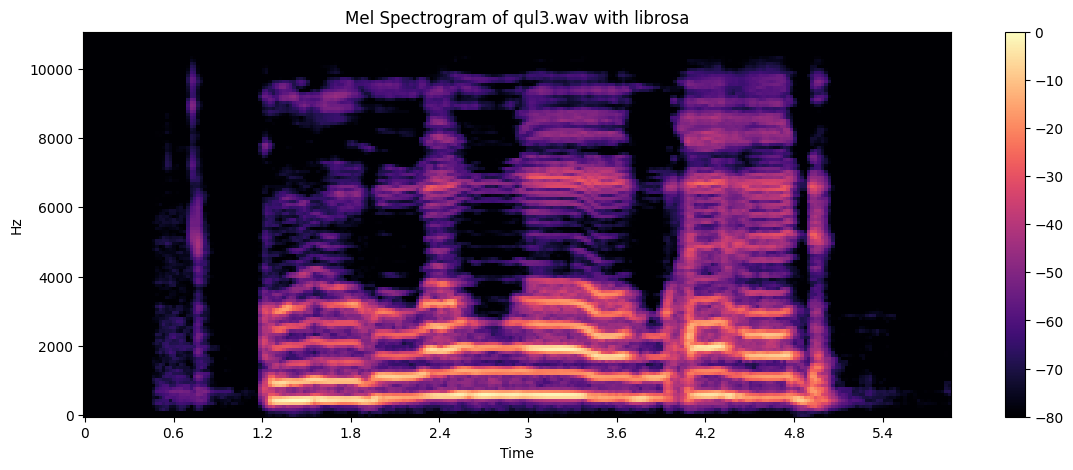

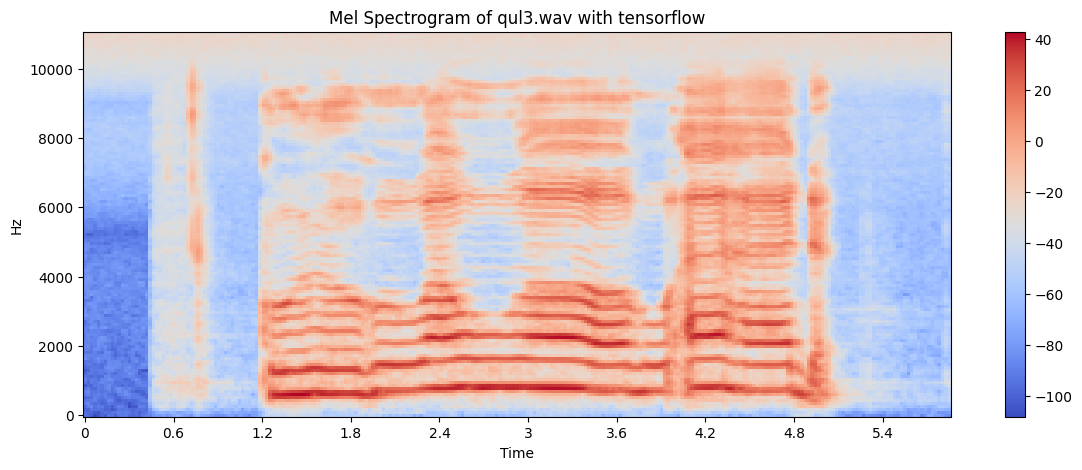

In [ ]:
index = -2

frame_size = 2048
hop_size = 512
n_mel = 128

mel_spec_lb = get_mel_spectrogram_lb(lb_audios[index], lb_srs[index], frame_size, hop_size, n_mel)
plot_spectrogram('Mel Spectrogram of ' +files[index]+" with librosa", mel_spec_lb, lb_srs[index])

mel_spec_tf = get_mel_spectrogram_tf(tf_audios[index].numpy(), tf_srs[index].numpy(), frame_size, hop_size, n_mel)
plot_spectrogram('Mel Spectrogram of ' + files[index]+" with tensorflow", mel_spec_tf.numpy(), tf_srs[index].numpy())

print("jumlah sample audio librosa", lb_audios[index].shape[0])
print("jumlah sample audio tensorflow", tf_audios[index].shape[0])
print("frekuensi bins", frame_size // 2 + 1)
print("frames librosa", (lb_audios[index].shape[0] - frame_size) // hop_size + 1)
print("frames tensorflow", (tf_audios[index].shape[0] - frame_size) // hop_size + 1)

print(mel_spec_lb.shape, mel_spec_tf.shape)